In [5]:
from sklearn.metrics import confusion_matrix
import json
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from constants import *
from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
from transformers import AutoTokenizer

# Looking at results from previous runs

In [43]:
LABEL_CONVERSIONS = {
                    "correct": '0',
                    "intrinsic-NP": '1',
                    "intrinsic-predicate": '2',
                    "extrinsic-NP": '3',
                    "extrinsic-predicate": '4'}

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')

def formatting_prompts_func(example, training=True):
    output_texts = []
    for i in range(len(example["error_type"])):
        text = f"{SYSTEM_INSTRUCTION}\n ### Text1: {example['doc'][i]}\n ### Text2: {example['summ'][i]}\n ### Output: "
        if training:
            text += (
                f"{LABEL_CONVERSIONS[example['error_type'][i]]} ." + tokenizer.eos_token
            )
        output_texts.append(text)
    return output_texts


def reformat_data_split_labels(dataset, dataset_name='Lislaam/AggreFact'):
    """Reformats the dataset to have the same format for all datasets for consistency.
    Args:
        dataset: dataset -- dataset to reformat
        dataset_name: str -- name of the dataset
    Returns:
        dataset: dataset -- reformatted dataset
    """
    def duplicate_and_label(example):
        """Duplicates examples with multiple error types, assigning one label per duplicate."""
        docs = []
        summs = []
        labels = []
        
        if example['errors'] is not None:
            try:
                lst = ast.literal_eval(example['errors'])
                for label in lst:
                    docs.append(example['doc'])
                    summs.append(example['summ'])
                    labels.append(label)
            except ValueError:  # If 'errors' is not a list, e.g., it is 'correct'
                docs.append(example['doc'])
                summs.append(example['summ'])
                labels.append(example['errors'])
        return [{'doc': doc, 'summ': summ, 'error_type': label} for doc, summ, label in zip(docs, summs, labels)]
    def process_in_chunks(dataset, chunk_size=10000, map_function=duplicate_and_label):
        chunked_tables = dataset.data.to_batches(max_chunksize=chunk_size)
        processed_chunks = []
        
        for chunk in chunked_tables:
            # Convert chunk to a PyArrow table
            chunk_table = pa.Table.from_batches([chunk])
            
            # Convert the chunk table to a pandas DataFrame
            chunk_df = chunk_table.to_pandas()
            
            if map_function:
                # Rename the column before splitting lists of errors into separate examples
                chunk_df = chunk_df.rename(columns={'error_type': 'errors'})
                
                # Apply the map function and flatten the result
                flattened_rows = chunk_df.apply(lambda row: map_function(row.to_dict()), axis=1).sum()
                
                # Convert the flattened list of dictionaries to a DataFrame
                chunk_df = pd.DataFrame(flattened_rows)
            
            processed_chunks.append(chunk_df)
        
        # Combine all processed chunks back into a single DataFrame
        combined_df = pd.concat(processed_chunks, ignore_index=True)
        
        return Dataset.from_pandas(combined_df)
    if dataset_name == "Lislaam/AggreFact":
        error_types = ['correct', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate']
        dataset = process_in_chunks(dataset)
        dataset = dataset.filter(lambda x: x['error_type'] in error_types)
        #dataset = dataset.filter(lambda x: len(x['doc']) < 1800)
        #dataset = dataset.map(error_type_map)
    else:
        raise ValueError(f"Dataset {dataset_name} not supported.")
    return dataset


def oversampling(dataset, error_types=['correct', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate'], n=2330):
    def replicate_class(dataset, error_type, n):
        filtered = dataset.filter(lambda x: x['error_type'] == error_type)
        num_examples = len(filtered)
        
        if num_examples == 0:
            return filtered  # Return empty dataset if no examples
        
        # Calculate how many times to replicate the dataset
        num_repeats = n // num_examples
        num_remaining = n % num_examples
        
        # Repeat the dataset and select the needed number of examples
        replicated = concatenate_datasets([filtered] * num_repeats)
        remaining = filtered.shuffle(seed=42).select(range(num_remaining))
        
        # Concatenate the replicated examples with the additional ones needed
        return concatenate_datasets([replicated, remaining])
    # Initialize an empty dataset for oversampling
    oversampled_dataset = Dataset.from_dict({
        'doc': [],
        'summ': [],
        'error_type': []
    })
    for error_type in error_types:
        oversampled = replicate_class(dataset, error_type, n)
        oversampled_dataset = concatenate_datasets([oversampled_dataset, oversampled])
    # Shuffle the final dataset
    oversampled_dataset = oversampled_dataset.shuffle(seed=42)
    return oversampled_dataset


def undersampling(dataset, error_types=['correct', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate'],
                    n=400):
    def sample_class(dataset, error_type, n):
        filtered = dataset.filter(lambda x: x['error_type'] == error_type)
        return filtered.shuffle(seed=42).select(range(min(n, len(filtered))))

    # Sample 400 examples from each class
    sampled_dataset = Dataset.from_dict({
        'doc': [],
        'summ': [],
        'error_type': []
    })

    for error_type in error_types:
        sampled = sample_class(dataset, error_type, n)
        sampled_dataset = concatenate_datasets([sampled_dataset, sampled])

    # Shuffle the final dataset
    sampled_dataset = sampled_dataset.shuffle(seed=42)

    return sampled_dataset


def extract(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Extract predictions and labels into lists
    true_labels = []
    predicted_labels = []

    for entry in data:
        true_labels.append(entry['label'])
        predicted_labels.append(entry['prediction'])

    return true_labels, predicted_labels

In [61]:
dataset = load_dataset("Lislaam/AggreFact", split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split
dataset = reformat_data_split_labels(dataset, "Lislaam/AggreFact") # Get rid of non-standard error_type examples and split data

#dataset = undersampling(dataset)

# Split the dataset into train and test sets (80% train, 20% test)
train_test = dataset.train_test_split(test_size=0.2)

# Further split the train set into train and validation sets (75% train, 25% validation of the original 80%)
train_valid = train_test['train'].train_test_split(test_size=0.25)

# Combine the splits into a DatasetDict
dataset = DatasetDict({
    'train': train_valid['train'],
    'validation': train_valid['test'],
    'test': train_test['test']
})

dataset = dataset.map(
    lambda x: {"formatted_text": formatting_prompts_func(x, False)},
    batched=True,
)

Map: 100%|██████████| 1185/1185 [00:00<00:00, 37651.70 examples/s]


In [64]:
# Define the label order to ensure both plots have the same order
label_order = ['correct', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP', 'extrinsic-predicate']

labels, preds = extract("fine_tuning safe copy/meta-llama/Meta-Llama-3-8B-Instruct/whole_dataset/summary.json")
len(labels), len(preds)

(1185, 1185)

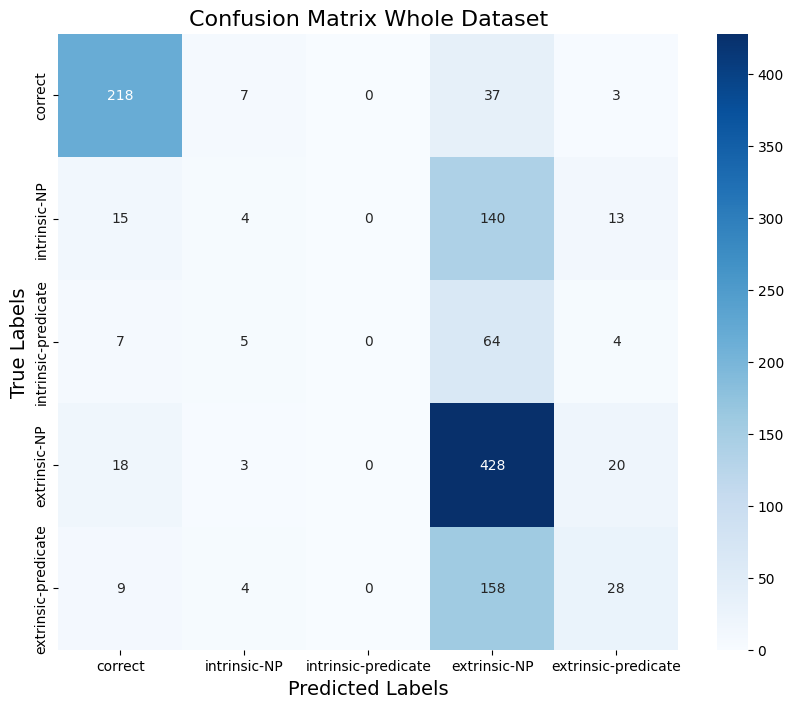

In [65]:
# Example label mappings (you can modify this based on your labels)
label_mapping = {
    'correct': 0,
    'intrinsic-NP': 1,
    'intrinsic-predicate': 2,
    'extrinsic-NP': 3,
    'extrinsic-predicate': 4
}

# Convert string labels to numeric labels
y_true_numeric = [label_mapping[label] for label in labels]
y_pred_numeric = [label_mapping[label] for label in preds]

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_numeric, y_pred_numeric)

# Plot confusion matrix with appropriate labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.keys()), 
            yticklabels=list(label_mapping.keys()))

plt.xlabel('Predicted Labels', size=14)
plt.ylabel('True Labels', size=14)
plt.title('Confusion Matrix Whole Dataset', size=16)
plt.show()

## Regression of labels and length

In [55]:
# Example: Load a tokenizer (if you're using a tokenizer for length calculation)
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')  # Adjust this to your model

# Add a new column with the tokenized length of each summary
def get_summary_length(example):
    example['summary_length'] = len(tokenizer.tokenize(example['summ']))
    return example

def get_doc_length(example):
    example['doc_length'] = len(tokenizer.tokenize(example['doc']))
    return example

# Apply the function to add summary length column
summary_lengths = dataset['test'].map(get_summary_length)
doc_lengths = dataset['test'].map(get_doc_length)
doc_lengths = doc_lengths['doc_length']

Map: 100%|██████████| 1185/1185 [00:01<00:00, 1023.34 examples/s]


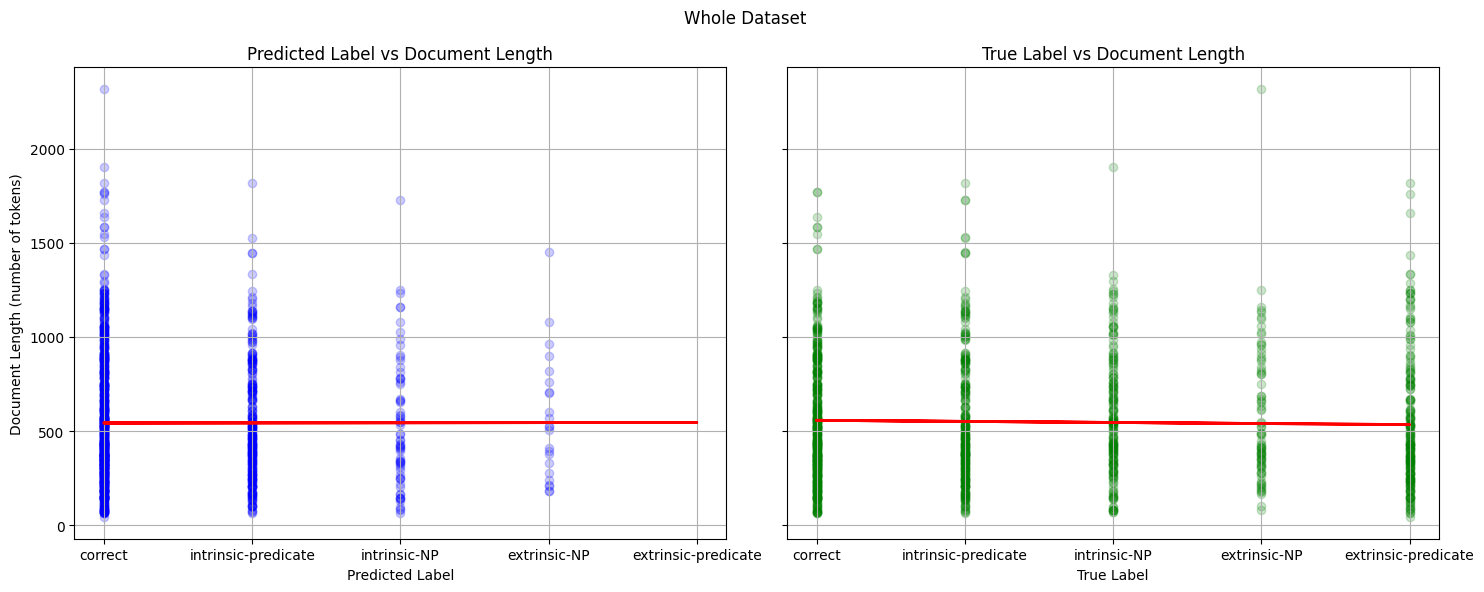

In [56]:
# Convert predicted and true labels to categorical data with a fixed order
predicted_labels = pd.Categorical(preds, categories=label_order, ordered=True)
true_labels = pd.Categorical(labels, categories=label_order, ordered=True)

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot 1: Predicted Label vs Document Length
axes[0].scatter(predicted_labels, doc_lengths, color='blue', alpha=0.2)
axes[0].set_title('Predicted Label vs Document Length')
axes[0].set_ylabel('Document Length (number of tokens)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticks(range(len(label_order)))
axes[0].set_xticklabels(label_order)
axes[0].grid(True)

# Fit and plot a line of best fit for predicted labels
pred_num_labels = [label_order.index(x) for x in predicted_labels]  # Convert categorical labels to numerical
coeffs_pred = np.polyfit(pred_num_labels, doc_lengths, 1)  # Get the slope and intercept for the best fit line
line_pred = np.polyval(coeffs_pred, pred_num_labels)  # Evaluate the line for each predicted label
axes[0].plot(pred_num_labels, line_pred, color='red', linewidth=2, label='Best Fit Line')

# Plot 2: True Label vs Document Length
axes[1].scatter(true_labels, doc_lengths, color='green', alpha=0.2)
axes[1].set_title('True Label vs Document Length')
axes[1].set_xlabel('True Label')
axes[1].set_xticks(range(len(label_order)))
axes[1].set_xticklabels(label_order)
axes[1].grid(True)

# Fit and plot a line of best fit for true labels
true_num_labels = [label_order.index(x) for x in true_labels]  # Convert categorical labels to numerical
coeffs_true = np.polyfit(true_num_labels, doc_lengths, 1)  # Get the slope and intercept for the best fit line
line_true = np.polyval(coeffs_true, true_num_labels)  # Evaluate the line for each true label
axes[1].plot(true_num_labels, line_true, color='red', linewidth=2, label='Best Fit Line')

fig.suptitle('Whole Dataset')
# Display both plots
plt.tight_layout()
plt.show()